In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import numpy as np
from PIL import Image
import torch.utils.data.dataset as datautil


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [2]:
# need to do this twice for it to work for some reason
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# Load preprocessed dataset mean and standard deviation 

Text(0.5,1,'Std image')

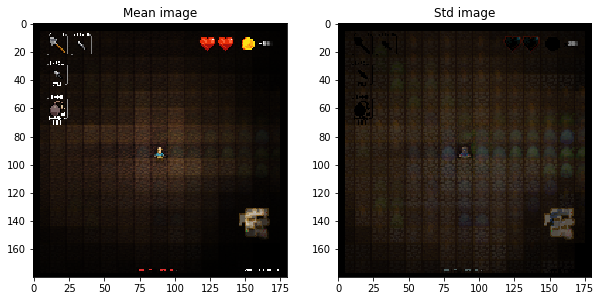

In [3]:
dset_mean = np.load("data/stats/dsetMean.npy")
dset_std = np.load("data/stats/dsetStd.npy")

plt.subplot(121)
plt.imshow(np.array(np.round(dset_mean), dtype=np.uint8))
plt.title("Mean image")
plt.subplot(122)
plt.imshow(np.array(np.round(dset_std), dtype=np.uint8))
plt.title("Std image")

Pytorch expects the data shape to be CxHxW (instead of the current HxWxC) so we reshape the mean and std image here, then use them to calculate the means for the three color channels. For images in the training data, this transposition is handled when the dataset object applies the ToTensor() transformation.

In [4]:
dset_mean = np.transpose(dset_mean, (2,0,1))
dset_std = np.transpose(dset_std, (2,0,1))
print(dset_mean.shape, dset_std.shape)

(3, 180, 180) (3, 180, 180)


Finally, calculate the mean and std over the three image channels.

In [5]:
channel_means = dset_mean.mean(axis=(1,2)) / 255
channel_stds = dset_mean.std(axis=(1,2)) / 255 #TODO: just conver to tensor so that you don't have to do this division manually

print("Per-channel means:")
print(channel_means)
print("Per-channel stds:")
print(channel_stds)

Per-channel means:
[0.10151469 0.06860853 0.04594935]
Per-channel stds:
[0.1226405  0.09382063 0.07829859]


# Initialize dataset and data loader objects
Use the channel mean and std to define a normalization transform which our dataset object will apply to each of its images upon loading them.

In [6]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])

usingQuad = True #using the 4 images in 1 or just individual images

# dataset = datasets.DatasetFolder(root='data/classes/normalized', extensions=['npy'], loader=np.load, transform=image_transform)
if usingQuad:
    dataset = datasets.ImageFolder(root='data/classes/downscaledQuad', transform=image_transform)
else:
    dataset = datasets.ImageFolder(root='data/classes/downscaledIndiv', transform=image_transform)
    
num_train = len(dataset)
print("Training set has {} examples.".format(num_train))

num_val = num_train//10

permutation = np.random.RandomState(seed=0).permutation(num_train)

val_dataset = datautil.Subset(dataset, permutation[:num_val])
train_dataset = datautil.Subset(dataset, permutation[num_val:])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_train-num_val)))

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=128,
                                           sampler=sampler.SubsetRandomSampler(range(num_val)))

Training set has 301 examples.


In [7]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images[0].shape)
print(dset_mean.shape)
#print(images[0])

# plt.imshow((images[0].numpy() * dset_std/255 + dset_mean/255).transpose(1,2,0))

# plt.imshow((images[0].numpy() * channel_stds.reshape((3,1,1)) + channel_means.reshape((3,1,1))).transpose(1,2,0))

torch.Size([3, 180, 720])
(3, 180, 180)


# Define training and validation functions

In [8]:
USE_GPU = False

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50000

print('using device:', device)

using device: cpu


In [14]:
def check_model_accuracy(loader, model, name): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            if usingQuad:
                split = (x[:,:,:,:180],x[:,:,:,180:360],x[:,:,:,360:540],x[:,:,:,540:720])
                scores = model(split)
            else:
                scores = model(x)
            
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('%s set: Got %d / %d correct (%.2f)' % (name, num_correct, num_samples, 100 * acc))
    return acc

In [15]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    train_losses, val_losses = [], []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            if usingQuad:
                split = (x[:,:,:,:180],x[:,:,:,180:360],x[:,:,:,360:540],x[:,:,:,540:720])
                scores = model(split)
            else:
                scores = model(x)
            
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                train_losses.append(check_model_accuracy(train_loader, model, 'Train'))
                val_losses.append(check_model_accuracy(val_loader, model, 'Val'))
                print()
    return (train_losses, val_losses)

# Load model defined in BCModel.py

In [16]:
from cloningCNN import CloningCNN
from cloningCNN import MultiSequentialCNN

#model = CloningCNN('original', dropout=1)
model = MultiSequentialCNN(netType='original', dropout=0) #this is drop probability

# you can use Nesterov momentum in optim.SGD
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                      momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters())


# Train on the dataset!

In [17]:
train_losses, val_losses = train_model(model, optimizer, epochs=15)

Iteration 0, loss = 1.3806
Train set: Got 106 / 271 correct (39.11)
Val set: Got 10 / 30 correct (33.33)

Iteration 0, loss = 1.4207
Train set: Got 103 / 271 correct (38.01)
Val set: Got 10 / 30 correct (33.33)

Iteration 0, loss = 1.2902
Train set: Got 143 / 271 correct (52.77)
Val set: Got 12 / 30 correct (40.00)

Iteration 0, loss = 1.0645
Train set: Got 158 / 271 correct (58.30)
Val set: Got 16 / 30 correct (53.33)

Iteration 0, loss = 0.9674
Train set: Got 172 / 271 correct (63.47)
Val set: Got 14 / 30 correct (46.67)

Iteration 0, loss = 0.7407
Train set: Got 208 / 271 correct (76.75)
Val set: Got 19 / 30 correct (63.33)

Iteration 0, loss = 0.5996
Train set: Got 226 / 271 correct (83.39)
Val set: Got 17 / 30 correct (56.67)



KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Accuracy")
plt.show()

In [ ]:
# ... after training, save your model 
torch.save(model.state_dict(), 'cloningCNN.pt')

In [ ]:
model.load_state_dict(torch.load("cloningCNN.pt"))

In [ ]:
check_model_accuracy(val_loader, model, 'Val')